---
## Note to Readers

VGG (Visual Geometry Group) networks were introduced by Karen Simonyan and Andrew Zisserman from the University of Oxford in their landmark 2014 paper “Very Deep Convolutional Networks for Large-Scale Image Recognition.” At ILSVRC 2014, VGG demonstrated that simply increasing network depth—while keeping a uniform architecture of 3×3 convolutions and 2×2 pooling—could achieve state-of-the-art performance on ImageNet.  

- **Historical Impact:**  
  - Showed the value of deeper, simpler building blocks in CNN design.  
  - Inspired many subsequent architectures (e.g., ResNet’s initial layers mirror VGG blocks).  
  - Became the de facto backbone for tasks like neural style transfer, object detection, and feature extraction.  

- **Why Include VGG Today?**  
  - Although modern research now favors architectures with residual connections (ResNet), mobile-optimized designs (MobileNet, EfficientNet), or transformer-based models (ViT), VGG remains a **cornerstone** in the evolution of deep learning.  
  - Its straightforward, sequential layout makes it an ideal **teaching tool**—you can see each convolution, activation, and pooling operation in order, without the complexity of skip-connections or attention modules.  
  - Pre-trained VGG weights are still widely used for **feature extraction** in many transfer-learning pipelines.

I’m uploading this notebook to GitHub as a **didactic** and **informative** resource for anyone—especially those, like myself, who are embarking on a **professional journey** in neural networks. Here you will find:

- A step-by-step implementation of each VGG variant (11, 13, 16, 19)  
- Explanations of key concepts like AdaptiveAvgPool, batch normalization, and transfer learning  
- Insights into VGG’s place in deep learning history and its lasting educational value  

Whether you’re new to CNNs or looking to solidify your understanding of foundational architectures, this notebook is designed to guide you through VGG’s elegant simplicity and historical significance.  
---

# 4 - VGG

In this notebook we will be implementing one of the [VGG](https://arxiv.org/abs/1409.1556) model variants. VGG is a convolutional neural network (CNN) architecture designed for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/), where it achieved top performance in 2014.

VGG is not a single model, but a family of models with different configurations.  
- Each configuration defines the number of layers and the size of each layer.  
- These configurations are shown in Table 1 of the [VGG paper](https://arxiv.org/pdf/1409.1556.pdf) and are denoted by letters (A, B, C, D, E).  
- More recently, they are referred to by the number of layers with weights — e.g. configuration "A" has 11 weighted layers and is called **VGG11**.

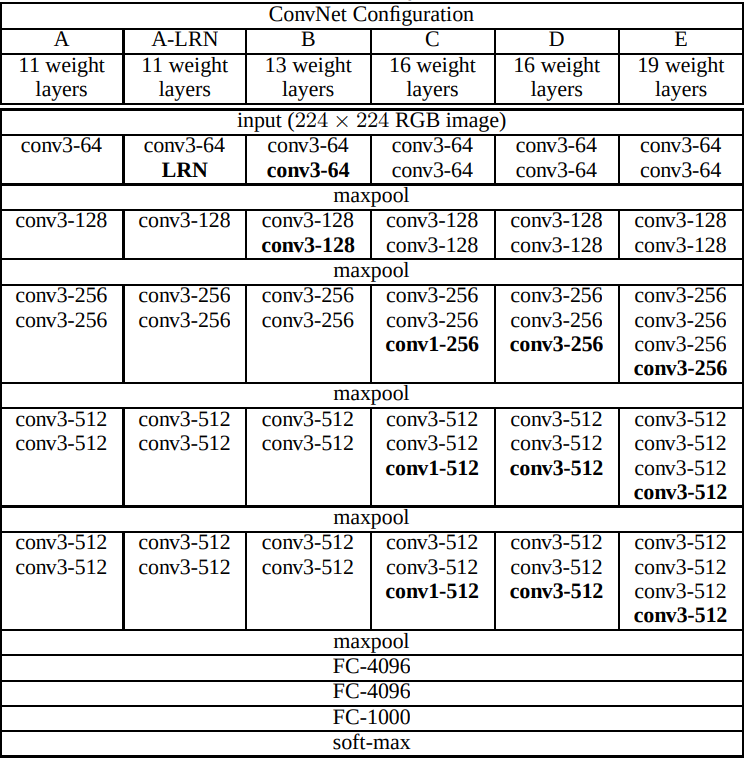

Below is the architecture for configuration "D", also known as **VGG16**, designed for 224×224 RGB images.

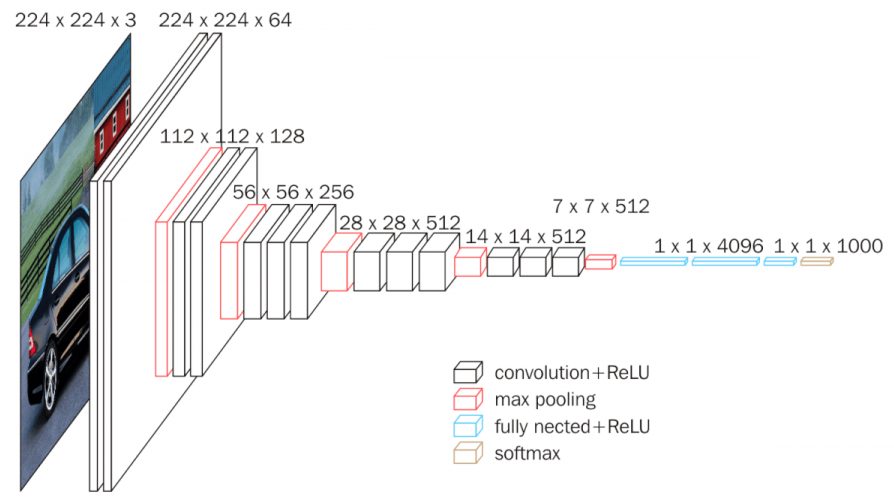

The most commonly used VGG variants are:  
- **VGG11** → configuration "A"  
- **VGG13** → configuration "B"  
- **VGG16** → configuration "D"  
- **VGG19** → configuration "E"

Less common variants include:  
- **A-LRN** → same as "A" but with Local Response Normalization  
- **C** → similar to "D" but with smaller filter sizes in some convolutional layers

We will be using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) and the learning rate finder introduced [here](https://arxiv.org/abs/1506.01186).  
However, this time we will be working with **pre-trained models**.

Normally, model weights are randomly initialized and then learned through training.  
Using a pre-trained model means some — or all — of the model’s weights come from a version already trained on a different task.  
- The pre-training task doesn’t have to match our own (the *downstream task*).  
- For example, a model trained to classify full images might later be adapted to detect objects within them.

The idea is that pre-trained models have already learned general high-level features that are useful across tasks.  
- This allows faster convergence and often leads to better performance.  
- In practice, they act as strong initializations for the training process.

This process is known as:  
- **Transfer learning** → transferring knowledge from one task to another  
- **Fine-tuning** → adjusting the pre-trained model on a new task  

These two terms are often used interchangeably in machine learning.

We will also explore a method called [**discriminative fine-tuning**](https://arxiv.org/abs/1801.06146), which was originally proposed for transfer learning in NLP but has also been successfully applied in computer vision.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

We'll also set the random seeds.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Defining the Model

Normally, the next step would be loading the data, but when using a pre-trained model, the process differs. First, we will introduce the VGG architecture and then show how to load a pre-trained VGG model.

## VGG Architecture

The fundamental VGG structure remains the same across all configurations, with only one variation: the `features` layer, which we pass as an argument when constructing the model.

A key component of this architecture is `AdaptiveAvgPool2d`. In addition to the standard `AvgPool` and `MaxPool` layers, PyTorch offers "adaptive" versions of these pooling layers. Instead of defining the kernel size, adaptive layers allow us to specify the desired output size. Here, we want an output of **7×7**.

Since all VGG configurations end with a convolutional layer containing **512 filters**, ensuring that the `features` layer always outputs **7×7** means we don’t have to modify the `classifier` for each configuration. This provides flexibility to apply the model to images of various sizes (minimum **32×32** pixels).

> **Note:** Although VGG can process images as small as 32×32, it is optimized for larger inputs. We’ll discuss strategies for smaller images later in the tutorial.

## Computing Filter Size for Adaptive Layers

For each dimension (height and width), the kernel size for an adaptive layer is computed as:

```python
filter_size = (input_size + desired_size - 1) // desired_size


In [3]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

Next up is calculating the `features` for each VGG configuration.

Typically, VGG configurations are defined as lists. Each item in the list is either:
- `'M'` → a max pooling layer  
- an integer → a convolutional layer with that many output channels

Below are the configurations for VGG11, VGG13, VGG16 and VGG19 (also known as configs "A", "B", "D" and "E" respectively):

In [4]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512,
                512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512,
                'M', 512, 512, 512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

## Defining the VGG Feature Extractor

We now define a helper function (`get_vgg_layers`) that, given a configuration list, constructs the corresponding `nn.Sequential` module of convolutional and pooling layers.  

- Each entry in the configuration list is either:  
  - `'M'` → denotes a `MaxPool2d(kernel_size=2, stride=2)` layer  
  - an integer → denotes a `Conv2d(in_channels, out_channels=<that integer>, kernel_size=3, padding=1)` followed by `ReLU(inplace=True)`

- All max-pool layers use a **2×2** kernel with stride **2** (the PyTorch default for pooling is `stride = kernel_size`).  
- All convolutional layers use a **3×3** kernel with **1**-pixel padding, followed immediately by ReLU.  
- After each convolution, we update `in_channels` to match the number of output channels, ensuring the next conv layer is correctly connected.

An optional **Batch Normalization** layer (`BatchNorm2d`) can be inserted after each convolution when `batch_norm=True`. BatchNorm:

- Normalizes each channel to zero mean and unit variance across the batch:  
  $$
  \begin{aligned}
    \mu_\mathcal{B} &= \frac{1}{m}\sum_{i=1}^m x_i, \\
    \sigma^2_\mathcal{B} &= \frac{1}{m}\sum_{i=1}^m (x_i - \mu_\mathcal{B})^2, \\
    \hat{x}_i &= \frac{x_i - \mu_\mathcal{B}}{\sqrt{\sigma^2_\mathcal{B} + \epsilon}},
  \end{aligned}
  $$
- Then scales and shifts each channel using learnable parameters $\gamma$ and $\beta$:  
  $$
    y_i = \gamma\,\hat{x}_i + \beta.
  $$

> **Why BatchNorm?**  
> 1. It stabilizes and accelerates training by reducing internal covariate shift.  
> 2. During inference, it uses running averages of mean/variance (not the batch statistics), avoiding issues with small batch sizes or single-image deployment.  
>
> Although the “textbook” order is to apply BatchNorm *after* the activation, the original VGG+BN paper placed it *before* ReLU—and we follow that convention here.

In [5]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

## VGG11 Features with Batch Normalization

Although the original VGG11 (configuration “A”) did not use batch normalization, it has become standard practice to include it for improved training stability and faster convergence.

- We use `cfgs['A']`, which corresponds to VGG11’s layer layout  
- By setting `batch_norm=True`, `BatchNorm2d` is inserted immediately after each convolution and before the ReLU  
- The final `nn.Sequential` alternates:
  - `Conv2d → BatchNorm2d → ReLU`
  - `MaxPool2d(kernel_size=2, stride=2)`

In [6]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)

## Verifying VGG11-BN Feature Layers

We can print out `vgg11_bn_features` and compare its sequence of layers to the original “A” configuration:

In [7]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## Constructing the VGG11 Model

Now that we have defined the `features` module for VGG11 with batch normalization, we can instantiate the full VGG11 model by passing it into our `VGGBase` class:

In [8]:
OUTPUT_DIM = 10

model = VGG(vgg11_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

### Pre-trained Models

In this notebook, we won’t train a VGG model from scratch (with randomly initialized weights). Instead, we’ll use a VGG model with **pre-trained** parameters—weights that have already been optimized on a large-scale dataset (usually ImageNet).

- **Benefits of using pre-trained weights**  
  - Speeds up convergence · the model starts from a strong initialization  
  - Improves performance · leverages features learned from millions of images  
  - Reduces data requirements · works well even on smaller datasets  

- **Loading a pre-trained VGG with `torchvision`**  
  1. Import the models submodule:  
     ```python
     from torchvision import models
     ```  
  2. Instantiate the desired VGG variant with `pretrained=True`:  
     ```python
     vgg16 = models.vgg16(pretrained=True)
     ```  
  3. (Optional) Freeze feature extractor weights if you only want to train the classifier:  
     ```python
     for param in vgg16.features.parameters():
         param.requires_grad = False
     ```

You can view all available pre-trained architectures in the [torchvision model zoo](https://pytorch.org/vision/stable/models.html).  

Let's import a pre-trained VGG11 with batch normalization. The first time this code is run the pre-trained parameters will be downloaded and are around 140MB for VGG11 with batch normalization.

In [9]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained=True)

print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

As shown above, the only difference between our custom VGG definitions and the pre-trained models from `torchvision` is the size of the final fully connected layer:

- All `torchvision` pre-trained VGG variants are trained on the [ImageNet](http://www.image-net.org/challenges/LSVRC/) dataset:  
  · Input size: 224×224 RGB images  
  · Number of classes: 1000

- Consequently, the final `Linear` layer in each pre-trained model has an output dimension of **1000**.

If you want to adapt a pre-trained VGG to a different number of classes (e.g., 10 for CIFAR-10), simply replace the last layer:

We can get the last layer specifically by indexing into the `classifier` layer of the pre-trained model.

In [10]:
pretrained_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

Since CIFAR-10 has only 10 classes, we need to replace the final linear layer (which currently outputs 1000) with one that outputs 10.

- The existing final layer’s input size is **4096** (the output of the previous `Linear` layer).  
- We’ll create a new `nn.Linear` with `in_features=4096` and `out_features=10`.  
- Then we assign it to `classifier[6]` (the 7th module in the `classifier` sequence).

In [11]:
IN_FEATURES = pretrained_model.classifier[-1].in_features

final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

We can directly overwrite the pre-trained classifier’s last layer with our new `final_fc` layer:

In [12]:
pretrained_model.classifier[-1] = final_fc

## Verifying the Modified Classifier

We can print out the `classifier` to confirm that the last layer now outputs 10 dimensions:

In [13]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


Since the `pretrained_model` provided by `torchvision.models.vggXX(pretrained=True)` only returns the final logits (and not the intermediate feature maps), we continue to use our custom `VGGBase` class which exposes both the feature extractor and classifier.

To transfer the pre-trained weights:

1. **Instantiate both models**  
   - `pretrained_vgg = models.vgg16(pretrained=True)`  
   - `custom_vgg   = VGGBase(vgg16_features, num_classes=10)`

2. **Load the state dict**  
   ```python
   # Copy all matching parameter tensors from the pre-trained model into our custom model
   custom_vgg.load_state_dict(pretrained_vgg.state_dict())


In [14]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

> **Model Size Comparison**  
> - **AlexNet**: ~23 million parameters  
> - **VGG (e.g. VGG16)**: ~128 million parameters  
>
> VGG’s deeper, more uniform architecture comes with a significant increase in parameter count, which often leads to better representational capacity but also requires more memory and compute resources.

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 128,812,810 trainable parameters


## Freezing Pre-trained Layers

Rather than fine-tuning every parameter inherited from a pre-trained model, we can choose to “freeze” some layers—i.e., keep their weights fixed—and only update a subset during training. This reduces the number of trainable parameters, which can:

- **Speed up training** (fewer gradients to compute)  
- **Lower memory usage** (less optimizer state)  
- **Enable training on smaller GPUs**

---

### Freezing the Feature Extractor

To freeze all convolutional and pooling layers (the `features` module):

```python
for param in model.features.parameters():
    param.requires_grad = False

### Data Processing

When using pre-trained models, data preprocessing must match the training conditions of the original model. According to the torchvision models [documentation](https://pytorch.org/docs/stable/torchvision/models.html):

> All pre-trained models expect input images normalized in the same way, i.e., mini-batches of 3-channel RGB images of shape `(3 × H × W)`, where H and W are at least 224. Images should be scaled to `[0, 1]` and then normalized using  
> ```
> mean = [0.485, 0.456, 0.406]
> std  = [0.229, 0.224, 0.225]
> ```

---

- **Resizing**  
  - CIFAR-10 images are 32×32, but VGG’s pre-trained classifier expects features at specific spatial locations in the 512×7×7 tensor after `AdaptiveAvgPool2d`.  
  - We must resize each image to **224×224** so that the flattened feature map aligns with the learned weights.

- **Color Normalization**  
  - Use the exact ImageNet means and standard deviations, not those computed from CIFAR-10.  
  - If we normalized CIFAR-10 with its own statistics, the pre-trained weights would receive “unnatural” inputs (e.g., light-green pixels treated as dark green), degrading performance.

- **Data Augmentation**  
  - Since we upsample to 224×224, we can apply stronger augmentations without losing image content.  
  - Typical transforms include `RandomCrop`, `RandomRotation`, and `HorizontalFlip`.

In [16]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [17]:
ROOT = '.data'

train_data = datasets.CIFAR10(ROOT,
                              train=True,
                              download=True,
                              transform=train_transforms)

test_data = datasets.CIFAR10(ROOT,
                             train=False,
                             download=True,
                             transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [19]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [20]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [21]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image


def plot_images(images, labels, classes, normalize=True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

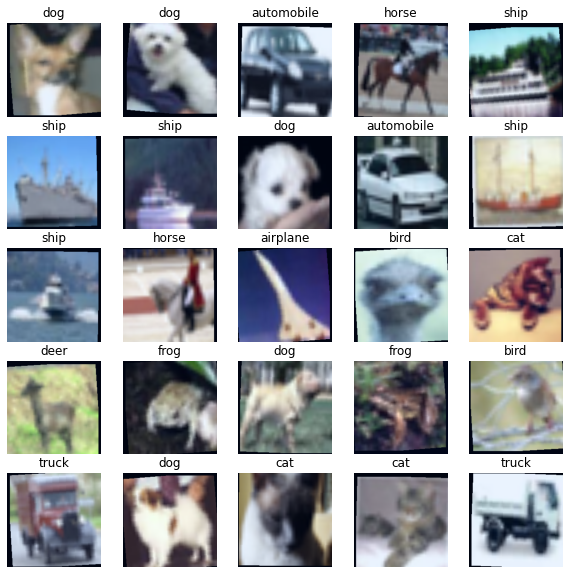

In [22]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in
                       [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [23]:
BATCH_SIZE = 128

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Training the Model

In this section we will fine-tune our pre-trained VGG model. We’ll use the **learning rate finder** to determine an optimal learning rate. Note that when fine-tuning, you generally use a **much smaller** learning rate than when training from scratch.

- **Learning Rate Finder**  
  - Perform a quick sweep from a very small LR (e.g. 1e-6) up to a moderate LR (e.g. 1e-1)  
  - Identify the LR at which the loss starts to decrease rapidly, then choose a value 5–10× lower for stable fine-tuning  

- **Optimizer Setup**  
  - Instantiate your optimizer (e.g. `torch.optim.SGD` or `torch.optim.Adam`)  
  - Initialize with the chosen base LR (often between 1e-4 and 1e-3)  
  - (Optional) Use **discriminative learning rates**: assign a lower LR to pre-trained `features` and a higher LR to the newly initialized `classifier`  

- **Device Configuration**  
  - Detect hardware with `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`  
  - Move both model and loss function to `device`:  
    ```python
    model.to(device)
    criterion.to(device)
    ```

- **Loss Function**  
  - Use a suitable classification loss, e.g. `nn.CrossEntropyLoss()`  
  - Ensure the criterion is on the same device as the model  

In [24]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [25]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in
                self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

### Learning Rate Finder

Before training, we use a **Learning Rate Finder** to identify an optimal learning rate. This method helps prevent wasting time with a poor choice of LR and often leads to faster convergence.

The idea is to:
1. Start with a very small learning rate (e.g., `1e-7`).
2. Gradually increase it exponentially over a number of mini-batches.
3. Record the loss at each learning rate.
4. Plot the learning rate vs. loss.
5. Choose a learning rate where the loss starts to decrease rapidly but hasn’t yet become unstable (i.e., before it shoots back up).

> This is especially helpful when fine-tuning a **pre-trained model** like VGG11, where inappropriate learning rates can either erase useful knowledge or slow down convergence significantly.

In practice:
- Use `torch_lr_finder` or implement a similar logic manually.
- Set your optimizer with a **very low initial LR**.
- After identifying the best LR, reinitialize your optimizer with that new LR for training.

In [26]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [27]:
def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

As we can see from the learning rate finder plot, the loss remains almost constant up until around $1 \times 10^{-4}$. After this point, it begins to decrease rapidly, indicating that the learning rate is becoming more effective for learning. Eventually, however, the loss begins to increase again, which suggests the learning rate has become too high and is causing the training to diverge.

A **good choice for the learning rate** is typically in the middle of this steepest decline — before the divergence starts. In our case, that value appears to be around **$5 \times 10^{-4}$**.

We will now reinitialize our optimizer using this learning rate and proceed to train the model.

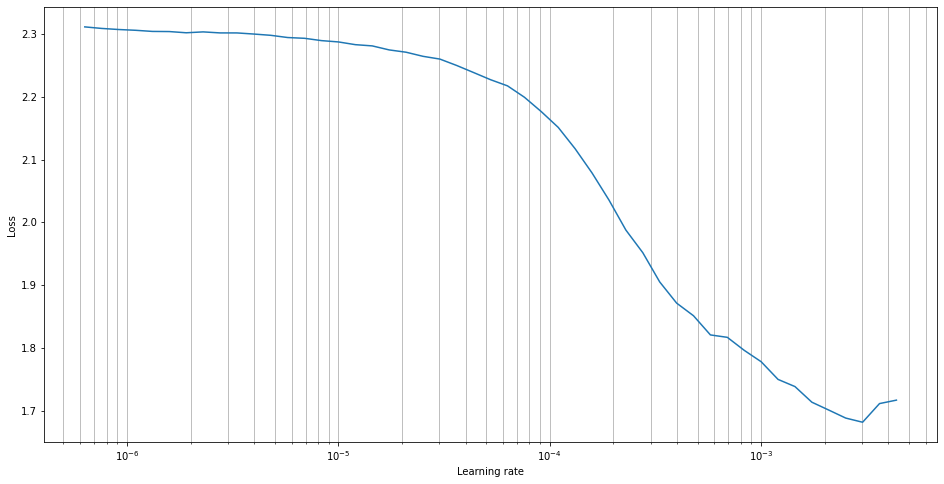

In [28]:
plot_lr_finder(lrs, losses, skip_start=10, skip_end=20)

We can now create an optimizer using the learning rate we identified from the learning rate finder and apply **discriminative fine-tuning**.

Discriminative fine-tuning is based on the idea that different layers in a neural network capture different types of features. In particular:

- **Earlier layers** tend to learn more general, low-level features (like edges, textures).
- **Later layers** learn more specific, task-dependent features (like object shapes or class-specific structures).

Because of this, when using a **pre-trained model**, we typically do not want to drastically change the parameters in the early layers — they already capture useful generic features. On the other hand, the later layers need to be fine-tuned more aggressively, especially the final classification layers which are specific to the original dataset (e.g., ImageNet) and not to our target dataset (e.g., CIFAR-10).

To implement this in PyTorch, we set different learning rates for different parameter groups. This is done by passing a list of dictionaries to the optimizer, where each dictionary specifies a `'params'` key and optionally overrides values like `'lr'`.

In our case, we will split the model's parameters into two groups:
- `features`: All convolutional layers. These will use a learning rate of `FOUND_LR / 10`.
- `classifier`: All fully connected layers. These will use `FOUND_LR`.

This strategy ensures that the convolutional base of the network is fine-tuned cautiously, while the final layers, which we expect to change more significantly, are trained with a higher learning rate.

**Note:** Discriminative fine-tuning is recommended **only** when performing transfer learning from a pre-trained model. If you're training a model from scratch, this technique is typically unnecessary.


In [29]:
FOUND_LR = 5e-4

params = [
          {'params': model.features.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.classifier.parameters()}
         ]

optimizer = optim.Adam(params, lr=FOUND_LR)

In [30]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [31]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [32]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Final Training Phase

At this stage, we proceed with training our model.

Since we are using a **pre-trained model** (VGG) and have **resized our CIFAR-10 images from 32x32 to 224x224**, the training process becomes computationally more intensive for two main reasons:

1. **Larger image size**: Larger images mean more data per sample and more operations per forward/backward pass.
2. **More parameters**: VGG, particularly compared to smaller models like AlexNet or custom CNNs, has a significantly higher number of parameters (~128 million), which increases both memory usage and training time.

Despite these costs, **transfer learning offers a major advantage**:  
We don’t need to train the entire model from scratch for dozens of epochs. Since most of the model's parameters are already well-initialized from training on ImageNet, we can achieve **very good accuracy in just a few epochs** by fine-tuning the model on our dataset.

Thus, even though each epoch may take longer, the total training time and computational cost are often much lower than training a model from scratch — with **better results**.

Let's go ahead and train our model using the optimizer and loss function we previously defined.

In [34]:
EPOCHS = 5

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 8m 15s
	Train Loss: 0.450 | Train Acc: 84.57%
	 Val. Loss: 0.266 |  Val. Acc: 91.09%
Epoch: 02 | Epoch Time: 8m 13s
	Train Loss: 0.215 | Train Acc: 92.82%
	 Val. Loss: 0.238 |  Val. Acc: 92.81%
Epoch: 03 | Epoch Time: 8m 15s
	Train Loss: 0.148 | Train Acc: 95.00%
	 Val. Loss: 0.228 |  Val. Acc: 93.24%
Epoch: 04 | Epoch Time: 8m 14s
	Train Loss: 0.107 | Train Acc: 96.45%
	 Val. Loss: 0.232 |  Val. Acc: 93.20%
Epoch: 05 | Epoch Time: 8m 14s
	Train Loss: 0.082 | Train Acc: 97.25%
	 Val. Loss: 0.240 |  Val. Acc: 93.61%


In [35]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.242 | Test Acc: 92.41%


### Examining the Model

We’ll evaluate the performance of our trained VGG model on the test dataset.

The first step in this evaluation is to obtain the model’s predictions for each of the examples in the test set. This allows us to later calculate important performance metrics such as accuracy, confusion matrix, and class-wise performance.

While our training setup leverages the advantages of transfer learning, it’s important to validate that these benefits actually translate into improved generalization on unseen data.

Let’s begin by getting the predictions for the test dataset.

In [36]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [37]:
images, labels, probs = get_predictions(model, test_iterator)

In [38]:
pred_labels = torch.argmax(probs, 1)

In [39]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=classes)
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    plt.xticks(rotation=20)

### Confusion Matrix

To better understand how our model is performing across the different classes, we’ll use a **confusion matrix**.

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class (or vice versa).

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while the off-diagonal elements are those that are mislabeled by the classifier.

This visualization allows us to identify:

- **Which classes are often confused with each other.**
- **Whether our model is biased towards certain classes.**
- **Specific weaknesses in the classifier.**

By analyzing this matrix, we can gain deeper insights than what overall accuracy alone can provide.

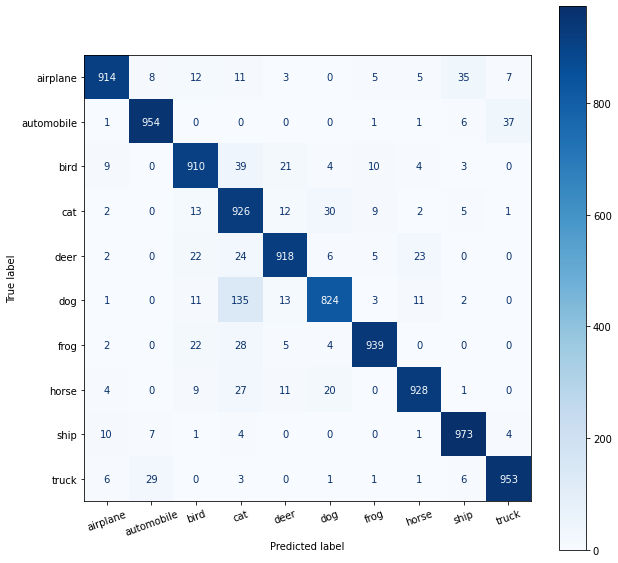

In [40]:
plot_confusion_matrix(labels, pred_labels, classes)

### Misclassified Predictions Analysis

After evaluating the overall performance of the model using metrics like accuracy and the confusion matrix, it is valuable to analyze the **incorrect predictions** in more detail.

In this step, we identify the examples from the test set that were **misclassified** by the model — where the predicted class does not match the true label. Then, we sort these incorrect predictions by the model's **confidence** (i.e., the predicted probability) in its incorrect choice.

This analysis helps to:

- Understand **which mistakes the model is most confident about**, which often indicate systematic biases or confusing examples.
- Identify **examples that might be mislabeled** in the dataset.
- Reveal **potential issues in the model’s training**, such as overfitting to specific patterns or lacking generalization.

By visualizing these high-confidence mistakes, we gain insights into how the model “thinks” and can guide further improvements in training, architecture, or data quality.

In [41]:
corrects = torch.eq(labels, pred_labels)

In [42]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [43]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

### Visualizing the Most Incorrect Predictions

In this section, we display the **top misclassified images** from the test set — specifically those where the model was **most confident yet wrong**.

We use the `plot_most_incorrect` function to visualize the top `N_IMAGES` (in this case, 36) of these misclassified examples. For each image shown, we include:

- The **true label**.
- The **predicted label**.
- The **confidence score** (probability) the model assigned to the incorrect prediction.

This kind of visualization allows us to:

- Identify patterns in the mistakes — for instance, certain classes being consistently confused with others.
- Detect potentially **ambiguous** or **difficult** test samples.
- Improve our understanding of the **limitations** of the model in real-world scenarios.

By analyzing what the model gets **confidently wrong**, we can uncover areas for improvement either in the dataset (e.g., more diverse or clearer samples) or in the model design itself.

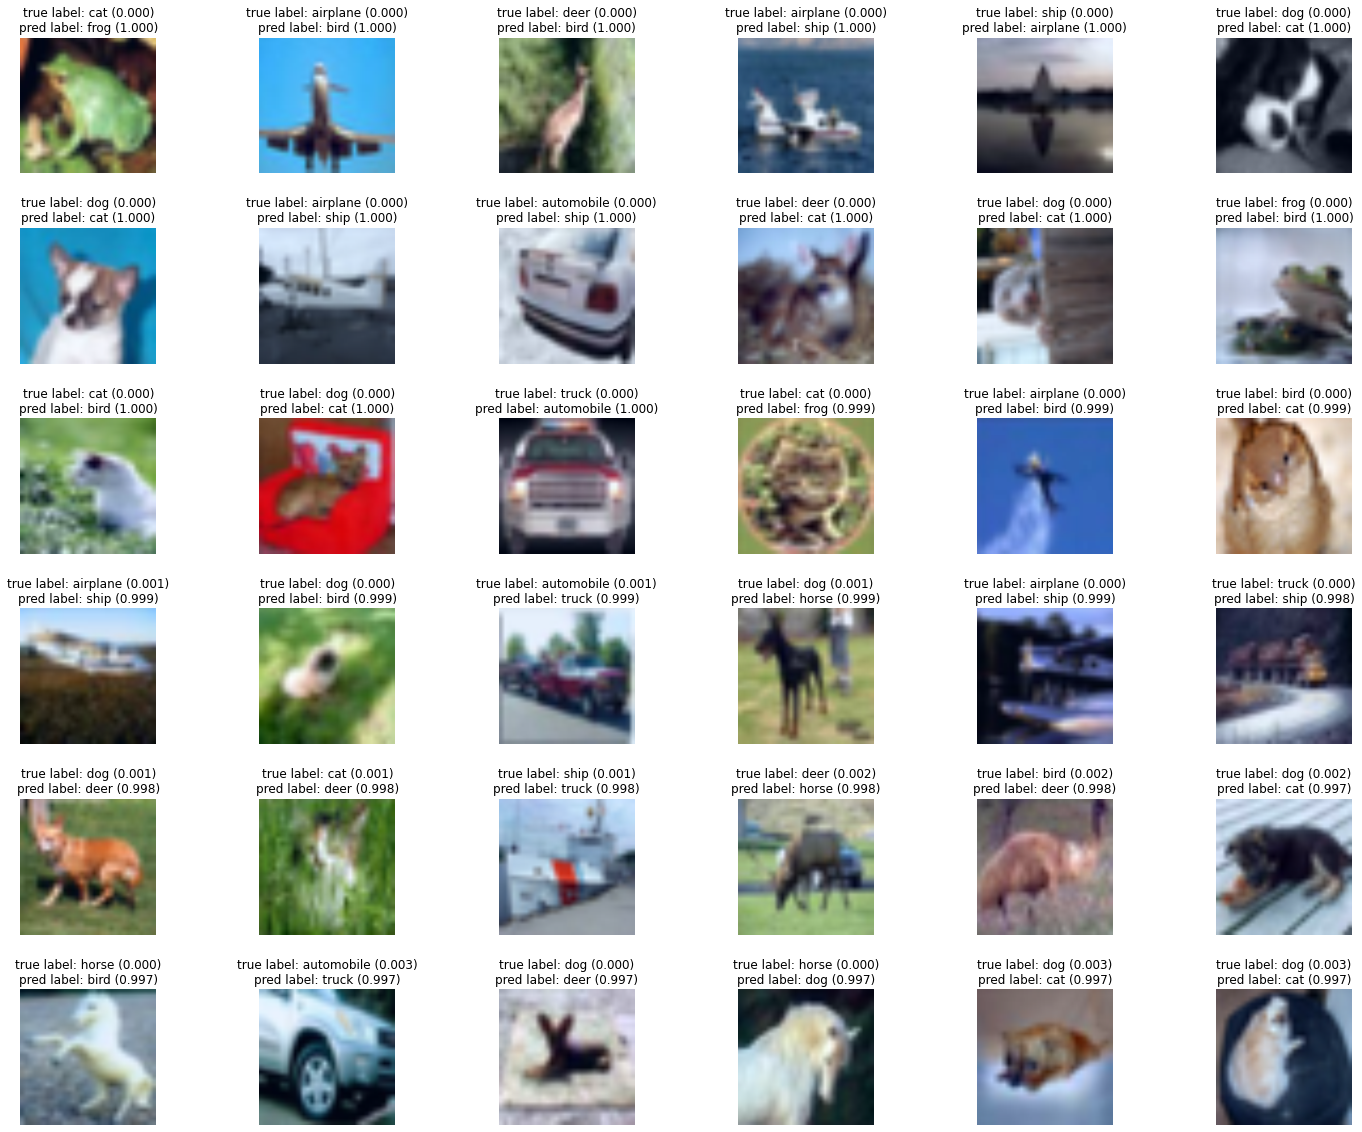

In [44]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

### Visualizing the Output Representations with PCA and t-SNE

Next, we aim to **visualize the learned output representations** of the model to better understand how it separates different classes in the feature space.

We will use two dimensionality reduction techniques:

- **PCA (Principal Component Analysis)**: A linear method that projects high-dimensional data into a lower-dimensional space by preserving variance.
- **t-SNE (t-distributed Stochastic Neighbor Embedding)**: A nonlinear technique particularly effective at preserving local structures and useful for visualizing high-dimensional data.

We will only visualize the **final output representations**, not the intermediate layers. This is due to the following reasons:

- The output representations are **only 10-dimensional**, corresponding to the number of classes in CIFAR-10.
- Intermediate representations can have **over 25,000 dimensions**, making them computationally expensive to store, reduce, and visualize meaningfully.

This analysis allows us to:

- Assess whether the model is effectively **clustering** similar classes.
- Spot potential **overlaps or ambiguities** between class boundaries.
- Identify outliers or anomalies in how the model represents the input space.

By visualizing how the model organizes data in its final layer, we gain intuition about its **internal logic** and **discriminative power**.

In [45]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, _ = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, labels

In [46]:
outputs, labels = get_representations(model, train_iterator)

In [47]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [48]:
def plot_representations(data, labels, classes, n_images=None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=classes)

### Plotting PCA Representations

We now proceed to visualize the final output representations of the model using **Principal Component Analysis (PCA)**.

PCA reduces the dimensionality of the data while retaining as much variance as possible. Since our model outputs a 10-dimensional vector (one for each CIFAR-10 class), we can use PCA to project these vectors down to 2 dimensions and visualize them in a 2D scatter plot.

In this plot:

- Each point represents an image from the test set.
- The position of the point is determined by the first two principal components of the model's output.
- Points are colored by their true class label.

This visualization helps us understand how the model clusters different classes in its output space. Well-separated clusters indicate that the model has learned to distinguish classes effectively.

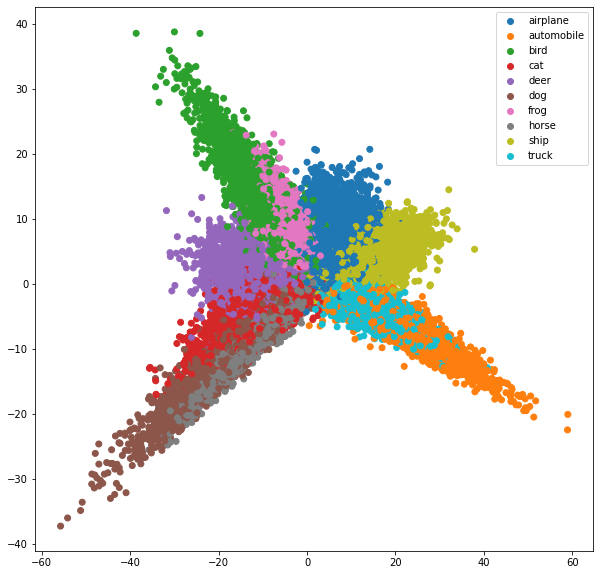

In [49]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, classes)

### Calculating t-SNE Representations

After PCA, we move on to **t-Distributed Stochastic Neighbor Embedding (t-SNE)** for visualization.

t-SNE is a nonlinear dimensionality reduction technique particularly well-suited for visualizing high-dimensional data in two or three dimensions. It focuses on preserving local structure, meaning that similar data points in high-dimensional space tend to stay close together in the low-dimensional embedding.

Because t-SNE is computationally intensive and sensitive to parameters, it is typically applied to lower-dimensional data — in this case, the 10-dimensional output vectors from our model.

By plotting the t-SNE results, we can gain insight into the model’s ability to group similar samples together and separate different classes, potentially revealing clusters or misclassifications not as clearly visible with PCA.

In [50]:
def get_tsne(data, n_components=2, n_images=None):

    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

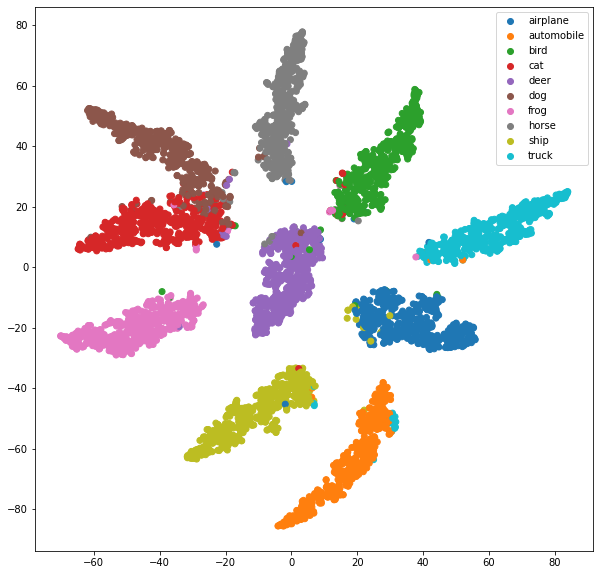

In [51]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, classes, n_images=N_IMAGES)

### Visualizing Learned Filters

Next, we'll extract the filters (also called kernels) learned by our model in the convolutional layers. These filters are responsible for detecting different features such as edges, textures, or patterns in the input images.

By applying these filters to sample images and visualizing the results, we can gain an intuitive understanding of what kind of features the model is focusing on at different layers.

This visualization helps demystify the "black box" nature of convolutional neural networks, showing us how raw pixel data is transformed step-by-step into meaningful representations used for classification.

In [52]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

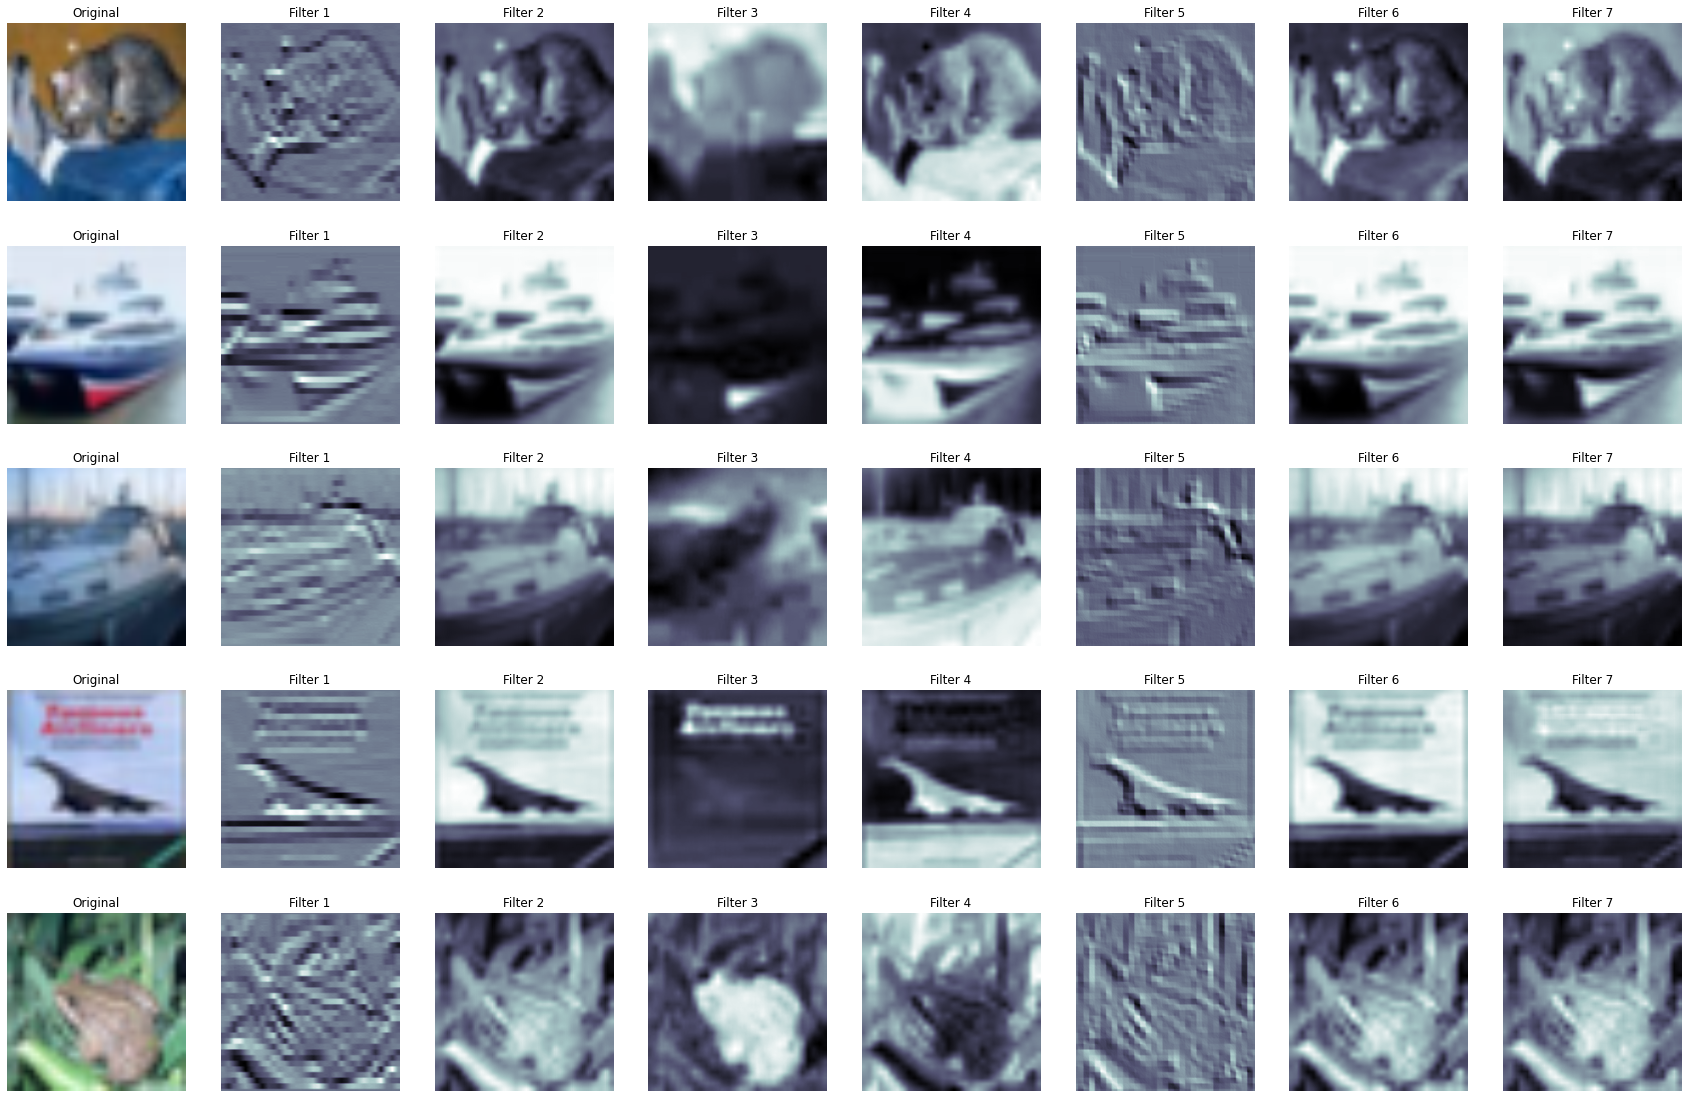

In [53]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

### Visualizing Filter Weights

In addition to applying filters to images, we can directly visualize the actual filter weights learned by the model, especially from the first convolutional layer.

These weights represent the patterns the model has learned to detect, such as edges, color blobs, or textures. Visualizing them as images provides insight into the kinds of low-level features the network focuses on when processing input images.

This step is particularly illuminating because the first-layer filters operate directly on the input pixels, making their learned patterns more interpretable to us.

In [54]:
def plot_filters(filters, normalize=True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize=(20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace=-0.9)

Although these filters may not be as immediately interpretable as some classic pre-trained filters, they still show more structure and interesting patterns compared to filters learned entirely from scratch.

Notably, several filters appear completely black, suggesting that their weights are essentially zero or very close to zero. This could mean that these filters were not significantly used during training or have been effectively "deactivated" by the learning process.

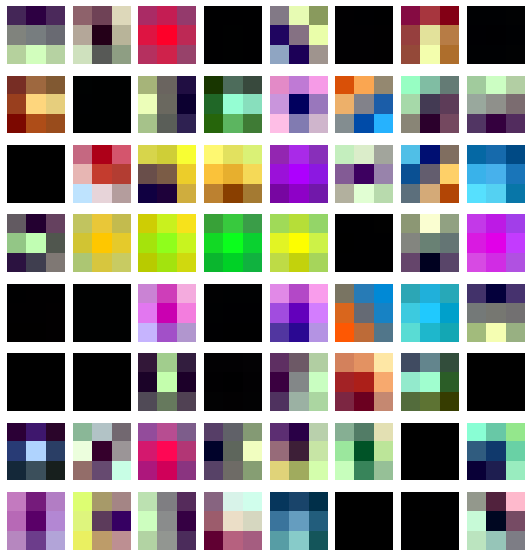

In [55]:
plot_filters(filters)

## Conclusions

In this notebook, we have explored the implementation and fine-tuning of a VGG11 model with batch normalization for image classification on the CIFAR10 dataset. Although VGG is no longer considered state-of-the-art in deep learning, understanding its architecture and transfer learning capabilities is invaluable for anyone beginning to work professionally with neural networks.

### Historical Context and Significance of VGG

The VGG network, introduced in 2014 by Simonyan and Zisserman, was a breakthrough architecture that demonstrated the power of deep convolutional networks with a very uniform and simple design: stacking small 3x3 convolutional filters with increasing depth. Despite its relatively straightforward design, VGG showed that increasing network depth dramatically improves performance on large-scale image recognition tasks like ImageNet.

The original VGG models did not include batch normalization, but later research showed that adding batch normalization significantly improves training stability and convergence. Although subsequent architectures such as ResNet and EfficientNet have surpassed VGG in both performance and efficiency, VGG remains a foundational model used extensively for educational purposes and as a baseline for transfer learning.

### Transfer Learning and Pretrained Models

One of the key advantages of modern deep learning workflows is the use of pre-trained models. We started by loading a VGG11 model pre-trained on ImageNet, a massive dataset with 1000 classes. Leveraging these pre-trained weights allows us to bypass the computationally expensive and time-consuming process of training from scratch, and instead fine-tune the model to our target dataset, CIFAR10, which only has 10 classes.

Through careful modification of the final fully connected layer, we adapted the model to our classification task. We emphasized the importance of resizing input images to 224x224 to maintain compatibility with the pre-trained classifier and used the exact normalization statistics from ImageNet to ensure the input data distribution matches what the model expects.

### Fine-tuning Strategy and Learning Rate Selection

We introduced the concept of discriminative fine-tuning, where different parts of the model are trained at different learning rates based on how general or specific the learned features are. The early convolutional layers, which extract generic visual features such as edges and textures, were assigned a lower learning rate, while the later fully connected layers, responsible for more task-specific classification, used a higher learning rate.

Using a learning rate finder, we systematically identified an optimal learning rate, ensuring efficient training with stable convergence. This approach resulted in a faster and more effective training process, demonstrating best practices when working with transfer learning.

### Data Preprocessing and Augmentation

Proper preprocessing was vital for this transfer learning workflow. We highlighted the necessity of resizing CIFAR10 images to the size expected by the pre-trained VGG network and applying ImageNet normalization parameters instead of dataset-specific means and standard deviations. This guarantees that the input distribution matches the pre-trained model’s expectations, preventing confusion and improving performance.

Additionally, we applied data augmentation techniques such as random rotations and cropping, which help the model generalize better by artificially increasing the diversity of training data.

### Model Evaluation and Interpretation

After training, we evaluated the model by generating a confusion matrix, providing a detailed overview of class-wise performance and identifying which classes the model confuses most often. We further explored the model's errors by visualizing the most confident incorrect predictions, giving us insights into potential failure modes.

Dimensionality reduction techniques such as PCA and t-SNE were used to visualize the learned feature space, illustrating how the model clusters different classes in lower-dimensional representations. These visualizations help us understand the internal structure of learned features and verify that the model separates classes meaningfully.

### Visualization of Learned Filters

We examined the filters learned by the model and compared them with those from AlexNet, both pre-trained and trained from scratch. While VGG’s filters were less immediately interpretable than AlexNet’s pre-trained filters, they still showed more structured patterns than filters learned from scratch. The presence of completely black filters suggests that some filters were not utilized effectively, highlighting areas for potential model pruning or optimization.

### Final Thoughts

Although VGG11 is not cutting-edge technology, working with it provides foundational knowledge about deep convolutional networks, transfer learning, and best practices in model training and evaluation. This notebook serves as a comprehensive guide for beginners transitioning to professional neural network work, offering insights from data preprocessing and model modification to fine-tuning, evaluation, and interpretation.

By sharing this notebook on GitHub, I aim to provide a resource that is both educational and practical, helping others understand not only how to implement a model but also why certain design decisions and training strategies are important. Mastering these fundamentals lays the groundwork for exploring more advanced architectures and techniques in deep learning.